<a href="https://colab.research.google.com/github/spiritofdragon/lung_tumor_segmentation/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install celluloid
!pip install numpy
!pip install torch
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 54.8 MB/s eta 0:00:00


In [ ]:
# Dataset

In [ ]:
from pathlib import Path
import numpy as np
import torch
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [ ]:
class LungDataset(torch.utils.data.Dataset):
  def __init__(self, root, augment_params):
    self.all_files = self.extract_files(root)
    self.augment_params = augment_params

  def extract_files(self, root):
    files = []
    for subject in root.glob("*"):
      slice_path = subject/"data"
      for slice in slice_path.glob("*.npy"):
        files.append(slice)
    return files

  def change_image_to_label_path(self, path):
    parts = list(path.parts)
    parts[parts.index("data")] = "masks"
    return Path(*parts)

  def augment(self, slice, mask):
    random_seed = torch.randint(0, 1000000, (1,))[0].item()
    imgaug.seed(random_seed)
    mask = mask.astype(bool)
    mask = SegmentationMapsOnImage(mask, mask.shape)
    slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps = mask)
    mask_aug = mask_aug.get_arr().astype(np.int32)
    return slice_aug, mask_aug

  def __len__(self):
    return len(self.all_files)

  def __getitem__(self, idx):
    file_path = self.all_files[idx]
    mask_path = self.change_image_to_label_path(file_path)
    slice = np.load(file_path, allow_pickle=True).astype(np.float32)
    mask = np.load(mask_path, allow_pickle=True)

    if self.augment_params:
      slice, mask = self.augment(slice, mask)

    return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [ ]:
# Model

In [ ]:
class DoubleConv(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                    torch.nn.ReLU())
  def forward(self, X):
    return self.step(X)

In [ ]:
class UNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = DoubleConv(1,64)
    self.layer2 = DoubleConv(64,128)
    self.layer3 = DoubleConv(128,256)
    self.layer4 = DoubleConv(256,512)

    self.layer5 = DoubleConv(512+256, 256)
    self.layer6 = DoubleConv(256+128, 128)
    self.layer7 = DoubleConv(128+64, 64)
    self.layer8 = torch.nn.Conv2d(64, 1, 1)

    self.maxpool = torch.nn.MaxPool2d(2)

  def forward (self, x):
    x1 = self.layer1(x)
    x1m = self.maxpool(x1)

    x2 = self.layer2(x1m)
    x2m = self.maxpool(x2)

    x3 = self.layer3(x2m)
    x3m = self.maxpool(x3)

    x4 = self.layer4(x3m)

    x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
    x5 = torch.cat([x5, x3], dim=1)
    x5 = self.layer5(x5)

    x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
    x6 = torch.cat([x6, x2], dim=1)
    x6 = self.layer6(x6)

    x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
    x7 = torch.cat([x7, x1], dim=1)
    x7 = self.layer7(x7)

    ret = self.layer8(x7)
    return ret

In [ ]:
# Testing

In [ ]:
model = UNet()

In [ ]:
random_input = torch.randn(1, 1, 256, 256)
ouput = model(random_input)
assert ouput.shape == torch.Size([1, 1, 256, 256])

In [ ]:
# Training

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from tqdm.notebook import tqdm
from celluloid import Camera

In [ ]:
# Dataset Creation

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [ ]:
# Create the dataset objects
train_path = Path("/content/drive/MyDrive/07-Lung-Tumor/Preprocessed/train")
val_path = Path("/content/drive/MyDrive/07-Lung-Tumor/Preprocessed/val")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14484 train images and 1283 val images


In [ ]:
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

In [ ]:
uniques = np.unique(target_list, return_counts=True)
uniques

In [ ]:
fraction = uniques[1][0] / uniques[1][1]
fraction

In [ ]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [ ]:
weight_list[:50]

In [ ]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

In [ ]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss


    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss


    def log_images(self, ct, pred, mask, name):

        results = []

        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5


        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [ ]:
# Instanciate the model
model = TumorSegmentation()

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [ ]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum

        return dice


In [ ]:
model = TumorSegmentation.load_from_checkpoint("/content/drive/MyDrive/07-Lung-Tumor/logs/lightning_logs/version_0/checkpoints/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:203: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file drive/MyDrive/07-Lung-Tumor/logs/lightning_logs/version_0/checkpoints/epoch=29-step=53759.ckpt`


In [ ]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1283 [00:00<?, ?it/s]

In [ ]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.804002583026886


In [ ]:
## visualized

In [ ]:
THRESHOLD = 0.5

In [ ]:
import nibabel as nib
import cv2

In [ ]:
subject = Path("/content/drive/MyDrive/07-Lung-Tumor/imagesTs/toThiHong.nii")
ct = nib.load(subject).get_fdata() / 3071  # standardize
#ct = ct[:,:,30:]  # crop

In [ ]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

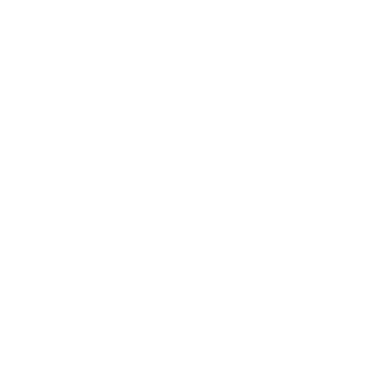

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="winter")  # Use autumn colormap to get red segmentation

    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
